<a href="https://colab.research.google.com/github/ErikFantomex/ProyectoBgDt/blob/main/ProyectoSCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Instalando spark en colab**

In [12]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

!tar xf spark-3.2.1-bin-hadoop3.2.tgz

!pip install -q findspark

Descargamos el conjunto de datos "Predict Future Sales"

In [ ]:


# Install Kaggle python package and create directory for kaggle credential
!pip install kaggle
!mkdir ~/.kaggle
# Copy the Kaggle credential to runtime machine (remember to mount the Google Drive containing the credential file)
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# Download the dataset and unzip
!kaggle competitions download -c competitive-data-science-predict-future-sales
!unzip competitive-data-science-predict-future-sales.zip



mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open competitive-data-science-predict-future-sales.zip, competitive-data-science-predict-future-sales.zip.zip or competitive-data-science-predict-future-sales.zip.ZIP.


Importamos las librerias y iniciamos el entorno

In [13]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Import Spark libraries
import findspark
findspark.init()

In [14]:


from pyspark.sql import functions as f
from pyspark.sql import SparkSession, Window
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.functions import vector_to_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [15]:
spark = (SparkSession
        .builder
        .appName('Lab 3 - SparkML: Regression')
        .getOrCreate()
)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

# **Cargar los conjuntos de datos de entrenamiento y prueba en Pyspark**

In [16]:


data = spark.read.csv("/content/drive/MyDrive/datasets/sales_train.csv", header = True, inferSchema = True)
test = spark.read.csv("/content/drive/MyDrive/datasets/test.csv", header=True, inferSchema=True)



In [17]:


# Imprime el esquema de la trama de datos
data.printSchema()
print("Test data schema")
test.printSchema()



Training data schema
root
 |-- date: string (nullable = true)
 |-- date_block_num: integer (nullable = true)
 |-- shop_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- item_price: double (nullable = true)
 |-- item_cnt_day: double (nullable = true)

Test data schema
root
 |-- ID: integer (nullable = true)
 |-- shop_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)



In [18]:
data.show(10)

+----------+--------------+-------+-------+----------+------------+
|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|
+----------+--------------+-------+-------+----------+------------+
|02.01.2013|             0|     59|  22154|     999.0|         1.0|
|03.01.2013|             0|     25|   2552|     899.0|         1.0|
|05.01.2013|             0|     25|   2552|     899.0|        -1.0|
|06.01.2013|             0|     25|   2554|   1709.05|         1.0|
|15.01.2013|             0|     25|   2555|    1099.0|         1.0|
|10.01.2013|             0|     25|   2564|     349.0|         1.0|
|02.01.2013|             0|     25|   2565|     549.0|         1.0|
|04.01.2013|             0|     25|   2572|     239.0|         1.0|
|11.01.2013|             0|     25|   2572|     299.0|         1.0|
|03.01.2013|             0|     25|   2573|     299.0|         3.0|
+----------+--------------+-------+-------+----------+------------+
only showing top 10 rows



In [19]:
print("Column number:", len(data.columns))
print("Raw data summary:")
data.summary().show()

Column number: 6
Raw data summary:
+-------+----------+-----------------+------------------+------------------+------------------+-----------------+
|summary|      date|   date_block_num|           shop_id|           item_id|        item_price|     item_cnt_day|
+-------+----------+-----------------+------------------+------------------+------------------+-----------------+
|  count|   2935849|          2935849|           2935849|           2935849|           2935849|          2935849|
|   mean|      null|14.56991146343017|33.001728290521754|10197.227056977385| 890.8532326980396|1.242640885140891|
| stddev|      null|9.422987708755963| 16.22697304833343|6324.2973538912065|1729.7996307126489|2.618834430895435|
|    min|01.01.2013|                0|                 0|                 0|              -1.0|            -22.0|
|    25%|      null|                7|                22|              4476|             249.0|              1.0|
|    50%|      null|               14|               

# Preprocesamiento de datos

In [20]:


# Perform semi join
train = (data.join(test, ["shop_id", "item_id"], "semi")
              .select(data.columns))
# See if the number of rows decreases
print("Rows after joining:", train.count())
print("Summary:")
train.summary().show()



Rows after joining: 1224439
Summary:
+-------+----------+------------------+------------------+------------------+------------------+-----------------+
|summary|      date|    date_block_num|           shop_id|           item_id|        item_price|     item_cnt_day|
+-------+----------+------------------+------------------+------------------+------------------+-----------------+
|  count|   1224439|           1224439|           1224439|           1224439|           1224439|          1224439|
|   mean|      null|19.354722448402903| 32.15116637088495| 9614.865821817175|1030.6659907978053|1.321234459209483|
| stddev|      null|  9.11072237679056|16.465624442549235|6299.8703350761325|1827.3837613285657|3.312996878793288|
|    min|01.01.2013|                 0|                 2|                30|               0.5|            -16.0|
|    25%|      null|                12|                19|              4181|             299.0|              1.0|
|    50%|      null|                21|    

In [21]:


train = train.where((train.item_price >= 0) & (train.item_cnt_day >= 0))
train.count()



1221498

In [22]:


train = (
    train.groupBy(["date_block_num", "shop_id", "item_id"]).agg(
        f.sum("item_price").alias("all_itemPrice_month"), # Sum of item prices by each item per month
        f.mean("item_price").alias("mean_itemPrice_month"), # Mean of item prices by each item per month
        f.sum("item_cnt_day").alias("item_cnt_month"), # Total item sold per month
        f.mean("item_cnt_day").alias("mean_itemCnt_month"), # Mean of item sold per month
        f.count("item_cnt_day").alias("days_sold_month") # Number of days the item is sold each month
    ).withColumnRenamed("date_block_num", "month_index")
)



In [23]:
train.summary().show()

+-------+------------------+-----------------+-----------------+-------------------+--------------------+------------------+------------------+------------------+
|summary|       month_index|          shop_id|          item_id|all_itemPrice_month|mean_itemPrice_month|    item_cnt_month|mean_itemCnt_month|   days_sold_month|
+-------+------------------+-----------------+-----------------+-------------------+--------------------+------------------+------------------+------------------+
|  count|            599912|           599912|           599912|             599912|              599912|            599912|            599912|            599912|
|   mean|20.158761618370693|32.06313926042486|10015.36912747203|  2095.652567542916|   911.0195486812893| 2.701724586272653|1.0957363340076394|2.0361286321993894|
| stddev| 9.139259988979074|16.88954154941829| 6192.91195449407|  6988.195273079581|  1563.8147208759856|11.292583509624817| 1.765562879428182|2.3191656679151755|
|    min|             

In [24]:
sampling_ratio = 1 # Change this if the data size is too large
itemPrices = train.select("all_itemPrice_month").rdd.map(lambda row: row.all_itemPrice_month).sample(False, sampling_ratio, 19127191).collect()
itemCounts = train.select("item_cnt_month").rdd.map(lambda row: row.item_cnt_month).sample(False, sampling_ratio, 19127191).collect()

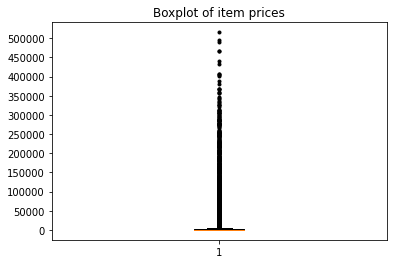

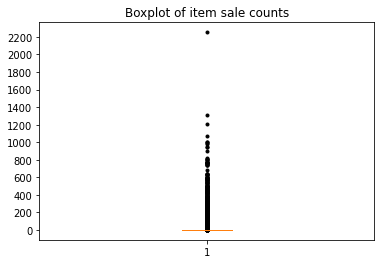

In [25]:
# Draw boxplots of the 2 features to check for outliers
# Item prices
plt.boxplot(itemPrices, sym='k.')
plt.yticks(np.arange(0, 550000, 50000))
plt.title("Boxplot of item prices")
plt.show()

print()
# Item sales
plt.boxplot(itemCounts, sym='k.')
plt.yticks(np.arange(0, 2400, 200))
plt.title("Boxplot of item sale counts")
plt.show()

In [26]:
train = train.where((train.all_itemPrice_month <= 400000) & (train.item_cnt_month <= 800))
train.count()

599887

In [27]:


combinations = (
    (train.select("month_index").distinct()).crossJoin(
        train.select("shop_id").distinct())
    ).crossJoin(
        train.select("item_id").distinct()
    )



In [28]:


train_monthly = train.join(combinations, ["month_index", "shop_id", "item_id"], "rightouter")
train_monthly = train_monthly.fillna(0) # fill missing values

# Perform a sort operation to keep the time series order
train_monthly = train_monthly.orderBy(["month_index", "shop_id", "item_id"], ascending=[1,1,1])



In [29]:


print("10 first samples:")
train_monthly.show(10)
print("Summary:")
train_monthly.summary().show()



10 first samples:
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+
|month_index|shop_id|item_id|all_itemPrice_month|mean_itemPrice_month|item_cnt_month|mean_itemCnt_month|days_sold_month|
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+
|          0|      2|     30|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     31|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     32|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     33|              499.0|               499.0|           1.0|               1.0|              1|
|          0|      2|     38|                0.0|                 0.0|           0.0|               0.0|              0|
|          0| 

# Exploratory Data Analysis (EDA)

In [30]:
train_monthly = (
    train_monthly.withColumn("month", train_monthly.month_index % 12)
                 .withColumn("year", (train_monthly.month_index / 12).cast("int") + 2013)
)
train_monthly.columns

['month_index',
 'shop_id',
 'item_id',
 'all_itemPrice_month',
 'mean_itemPrice_month',
 'item_cnt_month',
 'mean_itemCnt_month',
 'days_sold_month',
 'month',
 'year']

In [31]:
month_index_means = train_monthly.groupBy("month_index").agg(f.mean("item_cnt_month").alias("month_index_mean")).orderBy("month_index")
month_means = train_monthly.groupBy("month").agg(f.mean("item_cnt_month").alias("month_mean")).orderBy("month")

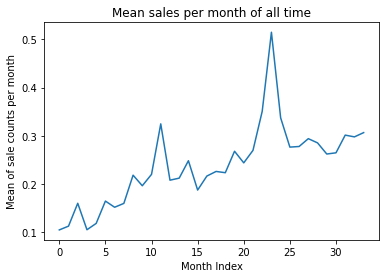

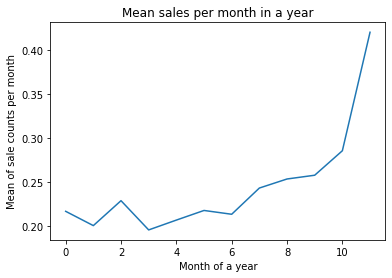

In [32]:


# Convert the data to a list using Spark RDD then plot it with mathplotlib
months = range(12)
month_indices = range(34)
lMonthMean = month_means.rdd.map(lambda row: row.month_mean).collect()
lMonthIdxMean = month_index_means.rdd.map(lambda row: row.month_index_mean).collect()

# Plot the lines
plt.plot(month_indices, lMonthIdxMean)
plt.xlabel("Month Index")
plt.ylabel("Mean of sale counts per month")
plt.title("Mean sales per month of all time")
plt.show()
print()
plt.plot(months, lMonthMean)
plt.xlabel("Month of a year")
plt.ylabel("Mean of sale counts per month")
plt.title("Mean sales per month in a year")
plt.show()



# Feature engineering

Después de realizar el preprocesamiento y el análisis, empezaremos a convertir los datos de las series temporales en datos de regresión. En primer lugar, vamos a crear la columna de predicción para nuestros datos.
Originalmente, este conjunto de datos utiliza item_cnt_month para la columna objetivo. Sin embargo, como serie temporal, lo que pretendemos predecir es el valor de las ventas del mes siguiente. Para convertir este problema en un problema de regresión, añadimos una columna que diga "predicción de ventas para el próximo mes" utilizando las ventas de la fila siguiente a la actual. Esta será nuestra columna objetivo.



In [34]:
window = Window.orderBy("month_index").partitionBy(["shop_id", "item_id"])
rolling_window = Window.orderBy("month_index").partitionBy(["shop_id", "item_id"]).rangeBetween(-2, 0)

In [35]:
train_monthly = train_monthly.select(
    "*",
    f.lag("item_cnt_month", offset=-1, default=0).over(window).alias("itemCnt_nextMonth")
)

In [36]:
train_monthly = train_monthly.select(
    "*",
    f.lag("item_cnt_month", offset=1, default=0).over(window).alias("itemCnt_lag_1"),
    f.lag("item_cnt_month", offset=2, default=0).over(window).alias("itemCnt_lag_2")
)

In [37]:
# Create the itemCnt_trendCycle feature
train_monthly = train_monthly.withColumn(
    "itemCnt_trendCycle",
    (train_monthly.item_cnt_month - train_monthly.itemCnt_lag_1 - train_monthly.itemCnt_lag_2) / 3
)

In [38]:
train_monthly = (train_monthly.withColumn("item_cnt_min", f.min("item_cnt_month").over(rolling_window))
                              .withColumn("item_cnt_max", f.max("item_cnt_month").over(rolling_window))
                              .withColumn("item_cnt_mean", f.mean("item_cnt_month").over(rolling_window))
                              .withColumn("item_cnt_std", f.stddev("item_cnt_month").over(rolling_window))
)

In [39]:
train_monthly = train_monthly.fillna(0)

In [41]:
print("First 10 samples:")
train_monthly.show(10)
print("Summary:")
train_monthly.summary().show()

First 10 samples:
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+-----+----+-----------------+-------------+-------------+-------------------+------------+------------+------------------+------------------+
|month_index|shop_id|item_id|all_itemPrice_month|mean_itemPrice_month|item_cnt_month|mean_itemCnt_month|days_sold_month|month|year|itemCnt_nextMonth|itemCnt_lag_1|itemCnt_lag_2| itemCnt_trendCycle|item_cnt_min|item_cnt_max|     item_cnt_mean|      item_cnt_std|
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+-----+----+-----------------+-------------+-------------+-------------------+------------+------------+------------------+------------------+
|          0|      2|     31|                0.0|                 0.0|           0.0|               0.0|              0|    0|2013|              4.0|          0.0|          0.0|                0.0

#Train-Validation Split

In [42]:


# Dividimos nuestros datos en 3 conjuntos
train_set = train_monthly.where("month_index > 1 and month_index < 24")
validation_set = train_monthly.where("month_index >= 24 and month_index < 33")
test_set = train_monthly.where("month_index == 33")

# Drop rows with null values
train_set = train_set.dropna()
validation_set = validation_set.dropna()


In [43]:
# Aggregate the mean encoding of categorical features
shop_mean = train_set.groupBy("shop_id").agg(f.mean("itemCnt_nextMonth").alias("shop_mean"))
item_mean = train_set.groupBy("item_id").agg(f.mean("itemCnt_nextMonth").alias("item_mean"))
year_mean = train_set.groupBy("year").agg(f.mean("itemCnt_nextMonth").alias("year_mean"))
month_mean = train_set.groupBy("month").agg(f.mean("itemCnt_nextMonth").alias("month_mean"))

In [44]:


# Add the mean encoding feature derived from training set to all sets
# Training set
train_set = train_set.join(shop_mean, ["shop_id"], "left")
train_set = train_set.join(item_mean, ["item_id"], "left")
train_set = train_set.join(year_mean, ["year"], "left")
train_set = train_set.join(month_mean, ["month"], "left")
train_set = train_set.withColumn("itemCnt_nextMonth", f.col("itemCnt_nextMonth").cast("int"))
train_set = train_set.drop("month_index") # Drop this column since we already have mean encoding of months and years

# Validation set
validation_set = validation_set.join(shop_mean, ["shop_id"], "left")
validation_set = validation_set.join(item_mean, ["item_id"], "left")
validation_set = validation_set.join(year_mean, ["year"], "left")
validation_set = validation_set.join(month_mean, ["month"], "left")
validation_set = validation_set.withColumn("itemCnt_nextMonth", f.col("itemCnt_nextMonth").cast("int"))
validation_set = validation_set.drop("month_index")

# Test set
test_set = test_set.join(shop_mean, ["shop_id"], "left")
test_set = test_set.join(item_mean, ["item_id"], "left")
test_set = test_set.join(year_mean, ["year"], "left")
test_set = test_set.join(month_mean, ["month"], "left")
test_set = test_set.withColumn("itemCnt_nextMonth", f.col("itemCnt_nextMonth").cast("int"))
test_set = test_set.drop("itemCnt_nextMonth")
test_set = test_set.drop("month_index")
# Add products which never exist in the training data during the record combination generation phase but is in the testing data
test_columns = test_set.columns
test_set = test.join(test_set, on=["shop_id", "item_id"], how="left")

# Reorder columns from all 3 sets to match each other
train_set = train_set.select(sorted(train_set.columns))
validation_set = validation_set.select(sorted(train_set.columns))
test_set = test_set.select(sorted(test_columns))

# Fill all null values with 0
train_set = train_set.fillna(0)
validation_set = validation_set.fillna(0)
test_set = test_set.fillna(0)



In [45]:
train_set.printSchema()
validation_set.printSchema()
test_set.printSchema()

root
 |-- all_itemPrice_month: double (nullable = false)
 |-- days_sold_month: long (nullable = true)
 |-- itemCnt_lag_1: double (nullable = false)
 |-- itemCnt_lag_2: double (nullable = false)
 |-- itemCnt_nextMonth: integer (nullable = true)
 |-- itemCnt_trendCycle: double (nullable = false)
 |-- item_cnt_max: double (nullable = false)
 |-- item_cnt_mean: double (nullable = false)
 |-- item_cnt_min: double (nullable = false)
 |-- item_cnt_month: double (nullable = false)
 |-- item_cnt_std: double (nullable = false)
 |-- item_id: integer (nullable = true)
 |-- item_mean: double (nullable = false)
 |-- mean_itemCnt_month: double (nullable = false)
 |-- mean_itemPrice_month: double (nullable = false)
 |-- month: integer (nullable = true)
 |-- month_mean: double (nullable = false)
 |-- shop_id: integer (nullable = true)
 |-- shop_mean: double (nullable = false)
 |-- year: integer (nullable = true)
 |-- year_mean: double (nullable = false)

root
 |-- all_itemPrice_month: double (nullable 

In [46]:
# Restructure training set
inputColumns = train_set.drop("itemCnt_nextMonth").columns
assembler1 = VectorAssembler(inputCols=inputColumns, outputCol="features")
train_assembled = assembler1.transform(train_set).select(["features", "itemCnt_nextMonth"])

# Restructure validation set
inputColumns = validation_set.drop("itemCnt_nextMonth").columns
assembler2 = VectorAssembler(inputCols=inputColumns, outputCol="features")
validation_assembled = assembler2.transform(validation_set).select(["features", "itemCnt_nextMonth"])

# Restructure test set
inputColumns = test_set.columns
assembler3 = VectorAssembler(inputCols=inputColumns, outputCol="features")
test_assembled = assembler3.transform(test_set).select(["features"])

In [47]:
# Check the schema again
train_assembled.printSchema()
validation_assembled.printSchema()
test_assembled.printSchema()

root
 |-- features: vector (nullable = true)
 |-- itemCnt_nextMonth: integer (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- itemCnt_nextMonth: integer (nullable = true)

root
 |-- features: vector (nullable = true)



In [55]:


train_maxVal = train_set.groupby().max('itemCnt_nextMonth').collect()[0].asDict()['max(itemCnt_nextMonth)']
train_minVal = train_set.groupby().min('itemCnt_nextMonth').collect()[0].asDict()['min(itemCnt_nextMonth)']
validation_maxVal = validation_set.groupby().max('itemCnt_nextMonth').collect()[0].asDict()['max(itemCnt_nextMonth)']
validation_minVal = validation_set.groupby().min('itemCnt_nextMonth').collect()[0].asDict()['min(itemCnt_nextMonth)']



#Modelando los datos

#Regresion lineal

In [48]:


# Rescale training set
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_assembled)
train_scaled = scaler_model.transform(train_assembled).select(["scaledFeatures", "itemCnt_nextMonth"])

# Rescale validation set
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(validation_assembled)
validation_scaled = scaler_model.transform(validation_assembled).select(["scaledFeatures", "itemCnt_nextMonth"])



# Antes de utilizar la regresión lineal, deberíamos utilizar un selector de características para reducir la dimensionalidad de los datos, lo que reducirá el tiempo de entrenamiento y el exceso de ajuste. Aquí utilizaremos el selector de características univariante para seleccionar el 30% de las mejores características del conjunto de entrenamiento. El selector se ajustará al conjunto de entrenamiento, y luego lo utilizaremos para transformar tanto el conjunto de entrenamiento como el de validación.

T

In [49]:
selector = UnivariateFeatureSelector(featuresCol="scaledFeatures", outputCol="selectedFeatures", labelCol="itemCnt_nextMonth", selectionMode="percentile")
selector.setFeatureType("continuous").setLabelType("continuous").setSelectionThreshold(0.3)
selector_model = selector.fit(train_scaled)
train_selected = selector_model.transform(train_scaled).select(["selectedFeatures", "itemCnt_nextMonth"])
validation_selected = selector_model.transform(validation_scaled).select(["selectedFeatures", "itemCnt_nextMonth"])

In [50]:
train_selected.head().selectedFeatures

DenseVector([0.1532, 2.1797, 2.2539, 3.0308, -3.592, 2.1551])




Así que se han seleccionado 6 características de entre las 20 del conjunto de entrenamiento. Utilizaremos la característica seleccionada para entrenar el modelo de regresión lineal.





In [51]:
lr = LinearRegression(featuresCol="selectedFeatures", labelCol="itemCnt_nextMonth", regParam=0.3, elasticNetParam=0.3, maxIter=10)
lr_model = lr.fit(train_selected)

In [52]:
trainingSummary = lr_model.summary
print("Train RMSE:", trainingSummary.rootMeanSquaredError)
print("Train Adjusted R2:", trainingSummary.r2adj)

Train RMSE: 2.221969755625813
Train Adjusted R2: 0.5499202422130905


El valor R2 ajustado indica que aproximadamente el 54,9% ~ 55% de los registros de nuestro conjunto de entrenamiento pueden utilizarse para explicar los registros objetivo. Esto se debe a que originalmente llenamos nuestro conjunto de entrenamiento con muchos registros vacíos utilizando las combinaciones de (month_index, shop_id, item_id). Mientras el valor R2 ajustado sea superior al 50%, podemos considerar que nuestro modelo es lo suficientemente bueno para la evaluación.
Para entender mejor el valor de RMSE, lo normalizamos con respecto al rango de resultados del conjunto de entrenamiento (máximo y mínimo de itemCnt_nextMonth). Esto escalará el RMSE entre 0 y 1. Cuanto más cerca esté de 0, más se ajusta nuestro modelo, pero si es completamente 0, significa que el modelo está sobreajustado por lo que debemos tener cuidado.

In [56]:


print("Normalized RMSE:", trainingSummary.rootMeanSquaredError / (train_maxVal - train_minVal))


Normalized RMSE: 0.002780938367491631


In [57]:


# Let the model predict the validation set
lr_predictions = lr_model.transform(validation_selected)

# Use a Regression Evaluator to evaluate the prediction results
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="itemCnt_nextMonth",metricName="rmse")
validation_rmse = lr_evaluator.evaluate(lr_predictions)
print("Validation RMSE:", validation_rmse)



Validation RMSE: 2.264954954079689


In [58]:


print("Normalized validation RMSE:", validation_rmse / (validation_maxVal - validation_minVal))



Normalized validation RMSE: 0.003052499938112788
